In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import trange, tqdm
from scipy import stats
from utils import *

np.random.seed(2)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Recreate some findings from the original paper
We start by replicating some figures produced in the original manuscript. To this end we start by testing out the code we've written to perform the recognition memory task they present

**Visualizing the task data**

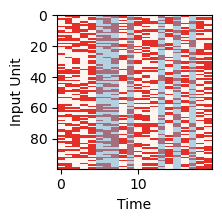

In [2]:
T = 20
R = 5
x,y = generate_dataset(T, R)

_, ax = plt.subplots(1,1, figsize = (2,2))
ax.imshow(x.T, aspect='auto', interpolation = 'none', vmax = 2,cmap = 'Reds')
yy = np.tile(y, (x.shape[1],1))
yy[yy==0] = np.nan
ax.imshow(yy, aspect='auto', interpolation = 'none', 
           alpha=0.5, vmax=2, vmin = 0, cmap='Blues')
ax.set_ylabel("Input Unit", fontsize = 10);
ax.set_xlabel("Time", fontsize = 10);

## Create the network and test its performance
For our purposes we will recreate the idealized version of the HebbFF network which requires no meta-learning. This version of the network is designed to maximize the capacity 

In [7]:
net = IdealHebbFF(d=100, n=5) 

**Evaluate performance as a function of the time delay for repeat trials**

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.25it/s]


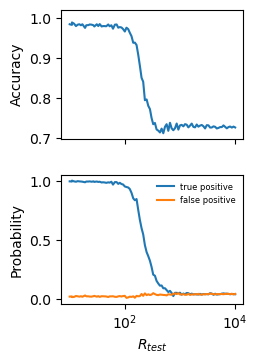

In [4]:
accs=[]
tprs = []
fprs = []

rs = np.round(np.logspace(1,4, 100)).astype(int)

for r in tqdm(rs):
    x,y = generate_dataset(max(2000, 3*r), r,  d=net.d)
    net.reset()
    yhats = np.empty(y.size)
    for i, (xi, yi) in enumerate(zip(x,y)):
        yhats[i] = net.forward(xi)
    accs.append(np.mean(yhats ==y))
    tprs.append(yhats[y.astype(bool)].mean())
    fprs.append(yhats[~y.astype(bool)].mean())


fig, ax = plt.subplots(2,1, figsize = (3,4))
ax[0].plot(rs[:len(accs)],accs)
ax[0].set_xscale('log')
ax[0].set_xticklabels([])
ax[0].set_ylabel("Accuracy", fontsize = 10)
ylim1 = (0.7,1.02)
ax[0].set_ylim(ylim1)
ax[1].plot(rs[:len(tprs)],tprs, label = "true positive")
ax[1].plot(rs[:len(tprs)],fprs, label = "false positive")
ax[1].set_xscale('log')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_xlabel(r"$R_{test}$", fontsize = 10)
ax[1].set_ylabel(r"Probability", fontsize = 10)
ax[1].legend(frameon=False, fontsize = 6)
ylim2 = ax[1].get_ylim()
fig.tight_layout(pad = 2.)

**Evaluate performance as a function of the length of the dataset**

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 25.25it/s]


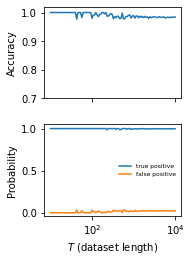

In [5]:
accs=[]
tprs = []
fprs = []

R = 5
ts = np.round(np.logspace(1,4, 100)).astype(int)


for t in tqdm(ts):
    x,y = generate_dataset(t, R,  d=net.d)
    net.reset()
    yhats = np.empty(y.size)
    for i, (xi, yi) in enumerate(zip(x,y)):
        yhats[i] = net.forward(xi)
    accs.append(np.mean(yhats ==y))
    tprs.append(yhats[y.astype(bool)].mean())
    fprs.append(yhats[~y.astype(bool)].mean())

fig, ax = plt.subplots(2,1, figsize =  (3,4))
ax[0].plot(ts[:len(accs)],accs)
ax[0].set_xscale('log')
ax[0].set_xticklabels([])
ax[0].set_ylabel("Accuracy")
ax[0].set_ylim(ylim1)
ax[1].plot(ts[:len(tprs)],tprs, label = "true positive")
ax[1].plot(ts[:len(fprs)],fprs, label = "false positive")
ax[1].set_xscale('log')
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_xlabel(r"$T$ (dataset length)", fontsize = 10)
ax[1].set_ylabel(r"Probability", fontsize = 10)
ax[1].set_ylim(ylim2)
ax[1].legend(frameon=False, fontsize = 6)
fig.tight_layout(pad = 2.)

**Is there repetition suppression in the hidden layer units?**


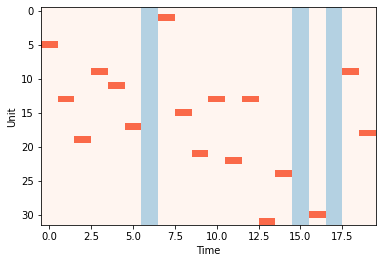

In [6]:
T = 20
x,y = generate_dataset(T, R, d=net.d)
net.reset()
yhats = np.empty(y.size)
hs = np.empty((net.N,T))
for i, xi in enumerate(x):
    _, h = net.forward(xi, ret_h = True)
    hs[:,i] = h
_, ax = plt.subplots(1,1, figsize = (6,4))
ax.imshow(hs, aspect='auto', interpolation = 'none', vmax = 2,cmap = 'Reds')
yy = np.tile(y, (net.N,1))
yy[yy==0] = np.nan
ax.imshow(yy, aspect='auto', interpolation = 'none', 
           alpha=0.5, vmax=2, vmin = 0, cmap='Blues')
ax.set_ylabel("Unit", fontsize = 10);
ax.set_xlabel("Time", fontsize = 10);

---
# Generalization
We now turn to the main question of whether or not this network can generalize well. As an intermediate question, it's worth considering how noisy an input can be and the network still recognize it. In other words if we freeze the plastic weights in the network, whats the maximum hamming distance away from a given memory where network can still recognize the input as a memory it has seen?

## A toy example

**How does accuracy over an entire session vary as a function of noise?**

In [8]:
T = 2000
R = 5
net.unfreeze()


accs=[]
tprs = []
fprs = []

hamm_ds = np.arange(0,100)
for hd in tqdm(hamm_ds):
    x,y = generate_dataset(T, R, d=net.d, noisy = True, noise = hd)
    net.reset()
    yhats = np.empty(y.size)
    for i, xi in enumerate(x):
        yhats[i] = net.forward(xi)
    accs.append(np.mean(yhats ==y))
    tprs.append(yhats[y.astype(bool)].mean())
    fprs.append(yhats[~y.astype(bool)].mean())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.75it/s]


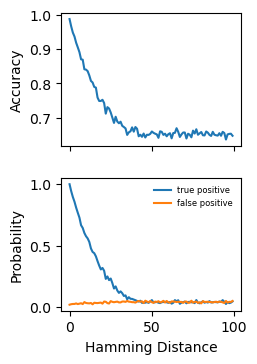

In [9]:
fig, ax = plt.subplots(2,1, figsize = (3,4))
ax[0].plot(hamm_ds[:len(accs)],accs)
ax[0].set_xticklabels([])
ax[0].set_ylabel("Accuracy")

ax[1].plot(hamm_ds[:len(tprs)],tprs, label = "true positive")
ax[1].plot(hamm_ds[:len(fprs)],fprs, label = "false positive")
ax[1].set_xlim(ax[0].get_xlim())
ax[1].set_xlabel(r"Hamming Distance")
ax[1].set_ylabel(r"Probability")

ax[1].legend(frameon=False, fontsize = 6)
fig.tight_layout(pad = 2.)

**For a given hamming distance, how does performance vary with the number of addressing weights $n$**

Note that $n$ indirectly effects the hidden layer size in the idealized network because the hidden layer has $2^n$ units

In [7]:
hd = 20
d = 100

accs = []
tprs = []
fprs = []

accs_rand = []
tprs_rand = []
fprs_rand = []

    
for n in trange(1,15):
    
    test_net = IdealHebbFF(d=d, n=n)
    _accs = []
    _tprs = []
    _fprs = []

    for _ in range(10):
        x, y = generate_dataset(T,R, d = d, noisy = False)
        test_net.reset()
        test_net.unfreeze()
        yhats = np.empty(y.size)
        for i, xi in enumerate(x):
            yhats[i] = test_net.forward(xi)
        _accs.append(np.mean(yhats ==y))
        _tprs.append(yhats[y.astype(bool)].mean())
        _fprs.append(yhats[~y.astype(bool)].mean())
        
    accs.append(np.mean(_accs))
    tprs.append(np.mean(_tprs))
    fprs.append(np.mean(_fprs))
    
    _accs_rand = []
    _tprs_rand = []
    _fprs_rand = []

    for _ in range(10):
        x, y = generate_dataset(T,R, d = d, noisy = True, noise = hd)
        test_net.reset()
        test_net.unfreeze()
        yhats = np.empty(y.size)
        for i, xi in enumerate(x):
            yhats[i] = test_net.forward(xi)
        _accs_rand.append(np.mean(yhats ==y))
        _tprs_rand.append(yhats[y.astype(bool)].mean())
        _fprs_rand.append(yhats[~y.astype(bool)].mean())
        
    accs_rand.append(np.mean(_accs_rand))
    tprs_rand.append(np.mean(_tprs_rand))
    fprs_rand.append(np.mean(_fprs_rand))

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 15/19 [14:19<03:49, 57.28s/it]


KeyboardInterrupt: 

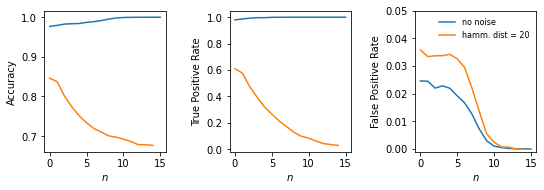

In [11]:
fig, ax = plt.subplots(1,3, figsize = (8,3))
ax[0].plot(accs)
ax[0].plot(accs_rand)
ax[0].set_xlabel(r"$n$")
ax[0].set_ylabel("Accuracy")


ax[1].plot(tprs)
ax[1].plot(tprs_rand)
ax[1].set_xlabel(r"$n$")
ax[1].set_ylabel("True Positive Rate")



ax[2].plot(fprs, label = 'no noise')
ax[2].plot(fprs_rand, label = 'hamm. dist = 20')
ax[2].set_xlabel(r"$n$")
ax[2].set_ylabel("False Positive Rate")
ax[2].set_ylim(-.001, .05)
ax[2].legend(frameon = False, fontsize=8)


fig.tight_layout(pad=2.)

**For a given hamming distance, how does performance vary with the dimensionality of the input $d$**

In [9]:
hd = 20
n = 5

accs = []
tprs = []
fprs = []

accs_rand = []
tprs_rand = []
fprs_rand = []

    
for d in trange(21,200):
    
    test_net = IdealHebbFF(d=d, n=n)
    _accs = []
    _tprs = []
    _fprs = []

    for _ in range(10):
        x, y = generate_dataset(T,R, d = d, noisy = False)
        test_net.reset()
        test_net.unfreeze()
        yhats = np.empty(y.size)
        for i, xi in enumerate(x):
            yhats[i] = test_net.forward(xi)
        _accs.append(np.mean(yhats ==y))
        _tprs.append(yhats[y.astype(bool)].mean())
        _fprs.append(yhats[~y.astype(bool)].mean())
        
    accs.append(np.mean(_accs))
    tprs.append(np.mean(_tprs))
    fprs.append(np.mean(_fprs))
    
    _accs_rand = []
    _tprs_rand = []
    _fprs_rand = []

    for _ in range(10):
        x, y = generate_dataset(T,R, d = d, noisy = True, noise = hd)
        test_net.reset()
        test_net.unfreeze()
        yhats = np.empty(y.size)
        for i, xi in enumerate(x):
            yhats[i] = test_net.forward(xi)
        _accs_rand.append(np.mean(yhats ==y))
        _tprs_rand.append(yhats[y.astype(bool)].mean())
        _fprs_rand.append(yhats[~y.astype(bool)].mean())
        
    accs_rand.append(np.mean(_accs_rand))
    tprs_rand.append(np.mean(_tprs_rand))
    fprs_rand.append(np.mean(_fprs_rand))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [03:28<00:00,  1.17s/it]


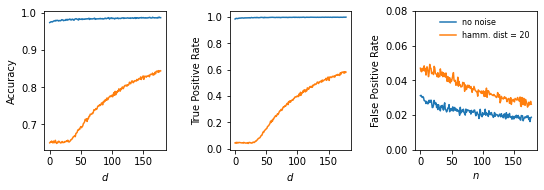

In [11]:
fig, ax = plt.subplots(1,3, figsize = (8,3))
ax[0].plot(accs)
ax[0].plot(accs_rand)
ax[0].set_xlabel(r"$d$")
ax[0].set_ylabel("Accuracy")


ax[1].plot(tprs)
ax[1].plot(tprs_rand)
ax[1].set_xlabel(r"$d$")
ax[1].set_ylabel("True Positive Rate")



ax[2].plot(fprs, label = 'no noise')
ax[2].plot(fprs_rand, label = 'hamm. dist = 20')
ax[2].set_ylim(0,.08)
ax[2].set_xlabel(r"$n$")
ax[2].set_ylabel("False Positive Rate")
ax[2].legend(frameon = False, fontsize=8)

fig.tight_layout(pad=2.)

## generalization on EMNIST

In [65]:
!wget -nc http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip
import zipfile
with zipfile.ZipFile('matlab.zip', 'r') as zip_ref:
    zip_ref.extractall('')

--2023-06-09 00:54:06--  http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip
Resolving www.itl.nist.gov (www.itl.nist.gov)... 132.163.4.175
Connecting to www.itl.nist.gov (www.itl.nist.gov)|132.163.4.175|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip [following]
--2023-06-09 00:54:06--  https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/matlab.zip
Connecting to www.itl.nist.gov (www.itl.nist.gov)|132.163.4.175|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 743900280 (709M) [application/zip]
Saving to: ‘matlab.zip’

matlab.zip          100%[===================>] 709.44M  1.86MB/s    in 7m 31s  

2023-06-09 01:01:37 (1.57 MB/s) - ‘matlab.zip’ saved [743900280/743900280]



In [12]:
from scipy.io import loadmat
from sklearn.decomposition import PCA

np.random.seed(10)
data = loadmat('matlab/emnist-balanced.mat')['dataset']
train_data = data['train'][0,0]['images'][0,0]
train_data_pc_obj = PCA().fit(train_data)
train_data_pc = train_data_pc_obj.transform(train_data)
train_labels = data['train'][0,0]['labels'][0,0].squeeze()
train_data_bin = 2* (train_data_pc>0).astype(int) - 1

**Visualize EMNIST classes**

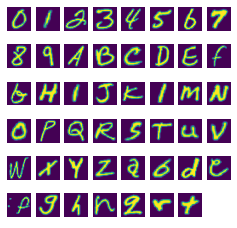

In [13]:
fig, ax = plt.subplots(6,8, figsize = (4,4))
for i,j in enumerate(np.unique(train_labels)):
    ax.flatten()[i].imshow(train_data[train_labels==j][0].reshape((28,28)).T)
    ax.flatten()[i].axis('off')
ax[-1,-1].axis('off');

**Visualize principle components**

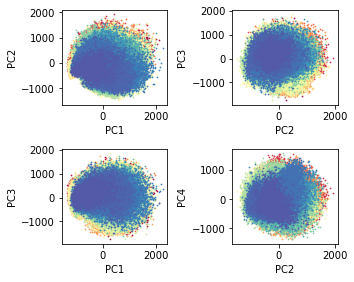

In [14]:
fig, ax = plt.subplots(2,2, figsize = (5,4))

ax[0,0].set_prop_cycle(color = sns.color_palette("Spectral", np.unique(train_labels).size))
for i in np.unique(train_labels):
    ax[0,0].scatter(train_data_pc[train_labels==i, 0], train_data_pc[train_labels==i, 1], marker='.', s=2)
ax[0,0].set_xlabel("PC1", fontsize = 10)
ax[0,0].set_ylabel("PC2", fontsize = 10)

ax[0,1].set_prop_cycle(color = sns.color_palette("Spectral", np.unique(train_labels).size))
for i in np.unique(train_labels):
    ax[0,1].scatter(train_data_pc[train_labels==i, 1], train_data_pc[train_labels==i, 2], marker='.', s=2)
ax[0,1].set_xlabel("PC2", fontsize = 10)
ax[0,1].set_ylabel("PC3", fontsize = 10)

ax[1,0].set_prop_cycle(color = sns.color_palette("Spectral", np.unique(train_labels).size))
for i in np.unique(train_labels):
    ax[1,0].scatter(train_data_pc[train_labels==i, 0], train_data_pc[train_labels==i, 2], marker='.', s=2)
ax[1,0].set_xlabel("PC1", fontsize = 10)
ax[1,0].set_ylabel("PC3", fontsize = 10)

ax[1,1].set_prop_cycle(color = sns.color_palette("Spectral", np.unique(train_labels).size))
for i in np.unique(train_labels):
    ax[1,1].scatter(train_data_pc[train_labels==i, 1], train_data_pc[train_labels==i, 3], marker='.', s=2)
ax[1,1].set_xlabel("PC2", fontsize = 10)
ax[1,1].set_ylabel("PC4", fontsize = 10)

fig.tight_layout(pad = 1.)

**compute pairwise within label hamming distances**

In [16]:
hamms = []
for i in tqdm(np.unique(train_labels)):
    tt = train_data_bin[train_labels==i][:,:100]
    hamm = (tt[:,:, None] != tt.T[None,:, :]).sum(axis=1)
    i,j = np.tril_indices(tt.shape[0])
    hamms.extend(list(hamm[i,j]))
hamm_sample = np.random.choice(hamms, 10000, replace = False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [01:07<00:00,  1.43s/it]


47.7106


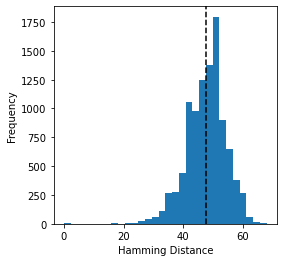

In [18]:
_, ax = plt.subplots(1,1, figsize = (4,4))
ax.hist(hamm_sample, 30);
ax.set_xlabel('Hamming Distance', fontsize = 10);
ax.set_ylabel('Frequency', fontsize = 10);
ax.axvline(hamm_sample.mean(), ls = '--', c='k')
print(hamm_sample.mean())

**test the network on this dataset**

In [19]:
accs = []
tprs = []
fprs = []

for _ in trange(100):
    x, y = generate_emnist_dataset(train_data_bin, train_labels, R, randomize = False)
    net.reset()
    net.unfreeze()
    yhats = np.empty(y.size)
    for i, xi in enumerate(x):
        yhats[i] = net.forward(xi)
    accs.append(np.mean(yhats ==y))
    tprs.append(yhats[y.astype(bool)].mean())
    fprs.append(yhats[~y.astype(bool)].mean())

accs = np.array(accs)
tprs = np.array(tprs)
fprs = np.array(fprs)
    

accs_rand=[]
tprs_rand = []
fprs_rand = []

for _ in trange(100):
    x, y = generate_emnist_dataset(train_data_bin, train_labels, R, randomize = True)
    net.reset()
    net.unfreeze()
    yhats = np.empty(y.size)
    for i, xi in enumerate(x):
        yhats[i] = net.forward(xi)
    accs_rand.append(np.mean(yhats ==y))
    tprs_rand.append(yhats[y.astype(bool)].mean())
    fprs_rand.append(yhats[~y.astype(bool)].mean())
    
accs_rand = np.array(accs_rand)
tprs_rand = np.array(tprs_rand)
fprs_rand = np.array(fprs_rand)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 14.74it/s]


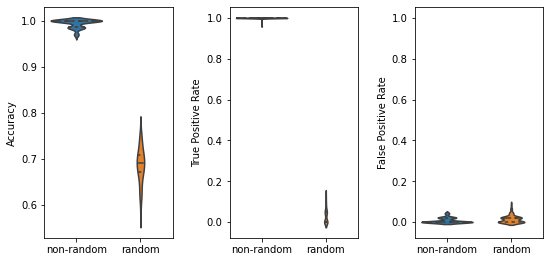

In [20]:
fig, ax = plt.subplots(1,3, figsize = (8,4))
sns.violinplot(data = [accs, accs_rand], inner = 'quartile', ax=ax[0])
ax[0].set_xticks([0,1])
ax[0].set_xticklabels(['non-random', 'random'], fontsize = 10)
ax[0].set_ylabel("Accuracy", fontsize = 10)

sns.violinplot(data = [tprs, tprs_rand], inner = 'quartile', ax=ax[1])
ax[1].set_xticks([0,1])
ax[1].set_xticklabels(['non-random', 'random'], fontsize = 10)
ax[1].set_ylabel("True Positive Rate", fontsize = 10)

sns.violinplot(data = [fprs, fprs_rand], inner = 'quartile', ax=ax[2])
ax[2].set_xticks([0,1])
ax[2].set_xticklabels(['non-random', 'random'], fontsize = 10)
ax[2].set_ylim(ax[1].get_ylim())
ax[2].set_ylabel("False Positive Rate", fontsize = 10)


fig.tight_layout(pad = 2.)


In [25]:
print('mean accuracy nonrandom', np.mean(accs),
      '\nmean accuracy random', np.mean(accs_rand))

mean accuracy nonrandom 0.9943120557118326 
mean accuracy random 0.6859783685912084


**test performance as a function of $n$**

In [26]:
d = 100

accs = []
tprs = []
fprs = []

accs_rand = []
tprs_rand = []
fprs_rand = []

    
for n in trange(1,15):
    
    test_net = IdealHebbFF(d=d, n=n)
    _accs = []
    _tprs = []
    _fprs = []

    for _ in range(10):
        x, y = generate_emnist_dataset(train_data_bin, train_labels,
                                       R, randomize = False)
        test_net.reset()
        test_net.unfreeze()
        yhats = np.empty(y.size)
        for i, xi in enumerate(x):
            yhats[i] = test_net.forward(xi)
        _accs.append(np.mean(yhats ==y))
        _tprs.append(yhats[y.astype(bool)].mean())
        _fprs.append(yhats[~y.astype(bool)].mean())
        
    accs.append(np.mean(_accs))
    tprs.append(np.mean(_tprs))
    fprs.append(np.mean(_fprs))
    
    _accs_rand = []
    _tprs_rand = []
    _fprs_rand = []

    for _ in range(10):
        x, y = generate_emnist_dataset(train_data_bin, train_labels,
                                       R, randomize = True)
        test_net.reset()
        test_net.unfreeze()
        yhats = np.empty(y.size)
        for i, xi in enumerate(x):
            yhats[i] = test_net.forward(xi)
        _accs_rand.append(np.mean(yhats ==y))
        _tprs_rand.append(yhats[y.astype(bool)].mean())
        _fprs_rand.append(yhats[~y.astype(bool)].mean())
        
    accs_rand.append(np.mean(_accs_rand))
    tprs_rand.append(np.mean(_tprs_rand))
    fprs_rand.append(np.mean(_fprs_rand))
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:25<00:00,  1.84s/it]


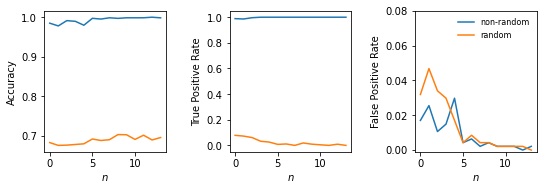

In [33]:
fig, ax = plt.subplots(1,3, figsize = (8,3))
ax[0].plot(accs)
ax[0].plot(accs_rand)
ax[0].set_xlabel(r"$n$")
ax[0].set_ylabel("Accuracy")


ax[1].plot(tprs)
ax[1].plot(tprs_rand)
ax[1].set_xlabel(r"$n$")
ax[1].set_ylabel("True Positive Rate")



ax[2].plot(fprs, label='non-random')
ax[2].plot(fprs_rand, label='random')
ax[2].set_ylim(ax[1].get_ylim())
ax[2].set_xlabel(r"$n$")
ax[2].set_ylabel("False Positive Rate")
ax[2].set_ylim(-0.001,0.08)
ax[2].legend(frameon=False, fontsize = 8)
fig.tight_layout(pad=2.)



**test performance as a function of $d$**

In [34]:
n = 5

accs = []
tprs = []
fprs = []

accs_rand = []
tprs_rand = []
fprs_rand = []

    
for d in trange(6,200):
    
    test_net = IdealHebbFF(d=d, n=n)
    _accs = []
    _tprs = []
    _fprs = []

    for _ in range(10):
        x, y = generate_emnist_dataset(train_data_bin, train_labels,
                                       R, d=d, randomize = False)
        test_net.reset()
        test_net.unfreeze()
        yhats = np.empty(y.size)
        for i, xi in enumerate(x):
            yhats[i] = test_net.forward(xi)
        _accs.append(np.mean(yhats ==y))
        _tprs.append(yhats[y.astype(bool)].mean())
        _fprs.append(yhats[~y.astype(bool)].mean())
        
    accs.append(np.mean(_accs))
    tprs.append(np.mean(_tprs))
    fprs.append(np.mean(_fprs))
    
    _accs_rand = []
    _tprs_rand = []
    _fprs_rand = []

    for _ in range(10):
        x, y = generate_emnist_dataset(train_data_bin, train_labels,
                                       R, d=d, randomize = True)
        test_net.reset()
        test_net.unfreeze()
        yhats = np.empty(y.size)
        for i, xi in enumerate(x):
            yhats[i] = test_net.forward(xi)
        _accs_rand.append(np.mean(yhats ==y))
        _tprs_rand.append(yhats[y.astype(bool)].mean())
        _fprs_rand.append(yhats[~y.astype(bool)].mean())
        
    accs_rand.append(np.mean(_accs_rand))
    tprs_rand.append(np.mean(_tprs_rand))
    fprs_rand.append(np.mean(_fprs_rand))
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 194/194 [03:40<00:00,  1.14s/it]


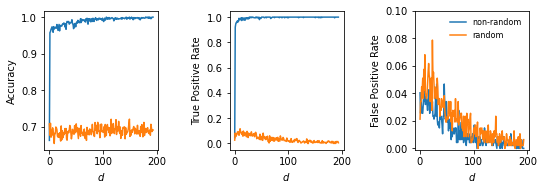

In [38]:
fig, ax = plt.subplots(1,3, figsize = (8,3))
ax[0].plot(accs)
ax[0].plot(accs_rand)
ax[0].set_xlabel(r"$d$")
ax[0].set_ylabel("Accuracy")


ax[1].plot(tprs)
ax[1].plot(tprs_rand)
ax[1].set_xlabel(r"$d$")
ax[1].set_ylabel("True Positive Rate")



ax[2].plot(fprs, label = 'non-random')
ax[2].plot(fprs_rand, label = 'random')
ax[2].set_ylim(-0.001, 0.1)
ax[2].set_xlabel(r"$d$")
ax[2].set_ylabel("False Positive Rate")
ax[2].legend(frameon=False, fontsize = 8)
fig.tight_layout(pad=2.)